# Part 2. Modeling

See other steps of the project: [notebook](https://colab.research.google.com/drive/1s0XYX2Rs55jqJtCglGXmHeakkTGe-5ha?usp=sharing)

## I. Preparation

### Install Spark

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
51 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recov

### Import Packages

In [2]:
import json
import os

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from collections import Counter

In [3]:
# Connect to the drive
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
DATA_PATH = "/content/drive/MyDrive/DSW/yelp_dataset"
FEATURE_PATH = "/content/drive/MyDrive/DSW/features"
TRANSFORMED_FEATURE_PATH = "/content/drive/MyDrive/DSW/transformed_features"

In [5]:
!ls -l $DATA_PATH
!ls -l $FEATURE_PATH
!ls -l $TRANSFORMED_FEATURE_PATH

total 9073854
-rw------- 1 root root  118863795 Jan 19  2022 yelp_academic_dataset_business.json
-rw------- 1 root root  286958945 Jan 19  2022 yelp_academic_dataset_checkin.json
-rw------- 1 root root 5341868833 Jan 19  2022 yelp_academic_dataset_review.json
-rw------- 1 root root  180604475 Jan 19  2022 yelp_academic_dataset_tip.json
-rw------- 1 root root 3363329011 Jan 19  2022 yelp_academic_dataset_user.json
total 1015568
-rw------- 1 root root  10195012 May 12 19:46 restaurant_features.csv
-rw------- 1 root root 381844567 May 12 19:47 review_df.csv
-rw------- 1 root root 595644167 May 12 19:47 user_features.csv
-rw------- 1 root root  52255945 May 12 19:47 user_id_to_index.json
total 868494
-rw------- 1 root root   2202200 May 12 19:47 business_id_to_index.json
-rw------- 1 root root 181965035 May 12 19:48 review_id_to_index.json
-rw------- 1 root root   9043712 May 12 19:47 transformed_restaurant_features.csv
-rw------- 1 root root 127527428 May 12 19:49 transformed_review_df.cs

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer

### Initialize a Spark Session

In [14]:
# Set up Spark session
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("RecommendationSystem")\
        .getOrCreate()

## II. Data Loading

### Load the tables

In [15]:
# Revew table
# review_df = spark.read.csv(os.path.join(TRANSFORMED_FEATURE_PATH, 'transformed_review_df.csv'), header=True, inferSchema=True)
review_df = spark.read.csv(os.path.join(TRANSFORMED_FEATURE_PATH, 'transformed_review_df_sample.csv'), header=True, inferSchema=True)
review_df = review_df.selectExpr("cast(user_id as int)", "cast(business_id as int)", "cast(stars as float)")
review_df.show(5)


+-------+-----------+-----+
|user_id|business_id|stars|
+-------+-----------+-----+
| 151344|      59659|  3.0|
|  29944|      51361|  4.0|
| 261703|      61502|  5.0|
| 343258|       6634|  5.0|
|   4952|       8229|  2.0|
+-------+-----------+-----+
only showing top 5 rows



In [16]:
# Restaurant features
restaurant_features = spark.read.csv(os.path.join(TRANSFORMED_FEATURE_PATH, 'transformed_restaurant_features.csv'), header=True, inferSchema=True)
restaurant_features = restaurant_features.withColumnRenamed('stars', 'restaurant_stars')
restaurant_features = restaurant_features.withColumnRenamed('review_count', 'restaurant_review_count')
restaurant_features.show(5)


+-----------+----------------+-----------------------+-------+--------------+----------------------+------------+--------+--------+----+----+------------------+-------+-----+--------+-------------+-------+-------------+------------+-----+------+---------+----+-------------------------+-------+--------+----------------------+-------+-----+----+-----------+-----+----------+-------+--------------+----------+--------------+------+-----------------------+-----------+-----+------------------+--------------------------+-----------+-------------------+------------------------+--------------+----+----------------------+----------+-------+------+------+---+-----+--------+-------+--------+-----+--------+------+-------+------+------+
|business_id|restaurant_stars|restaurant_review_count|is_open|American (New)|American (Traditional)|Asian Fusion|Bakeries|Barbeque|Bars|Beer|Breakfast & Brunch|Burgers|Cafes|Caterers|Chicken Wings|Chinese|Cocktail Bars|Coffee & Tea|Delis|Diners|Fast Food|Food|Ice Crea

In [17]:
# User features
user_features = spark.read.csv(os.path.join(TRANSFORMED_FEATURE_PATH, 'transformed_user_features.csv'), header=True, inferSchema=True)
user_features = user_features.withColumnRenamed('review_count', 'user_review_count')
user_features.show(5)


+-------+---------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+---+-------------+
|user_id|rescaled_friend_count| user_review_count|            useful|             funny|              cool|              fans|   elite_year_count|   compliment_hot|   compliment_more| compliment_profile|    compliment_cute|    compliment_list|   compliment_note|  compliment_plain|    compliment_cool|   compliment_funny|  compliment_writer| compliment_photos|age|average_stars|
+-------+---------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+-------------------+-------------------

**Merge the features onto the review table:**

Each row represents a user-restaurant interaction with corresponding user and restaurant features

In [18]:
# Join the user features and restaurant features with the review table
# Join review_df with restaurant_features
review_restaurant_df = review_df.join(restaurant_features, review_df.business_id == restaurant_features.business_id, "left")
review_restaurant_df = review_restaurant_df.drop(restaurant_features.business_id)  # Drop duplicate column

# Join with user_features
full_data_df = review_restaurant_df.join(user_features, review_restaurant_df.user_id == user_features.user_id, "left")
full_data_df = full_data_df.drop(user_features.user_id)  # Drop duplicate column

# Show the first few rows of the joined DataFrame
full_data_df.show(5)

+-------+-----------+-----+----------------+-----------------------+-------+--------------+----------------------+------------+--------+--------+----+----+------------------+-------+-----+--------+-------------+-------+-------------+------------+-----+------+---------+----+-------------------------+-------+--------+----------------------+-------+-----+----+-----------+-----+----------+-------+--------------+----------+--------------+------+-----------------------+-----------+-----+------------------+--------------------------+-----------+-------------------+------------------------+--------------+----+----------------------+----------+-------+------+------+---+-----+--------+-------+--------+-----+--------+------+-------+------+------+---------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------

### Feature columns

In [19]:
# Restaurant feature columns
restaurant_feature_cols = {}

restaurant_category_cols = [
    "Restaurants",
    "Food",
    "Bars",
    "Sandwiches",
    "American (Traditional)",
    "Pizza",
    "Coffee & Tea",
    "Fast Food",
    "Breakfast & Brunch",
    "American (New)",
    "Burgers",
    "Mexican",
    "Italian",
    "Specialty Food",
    "Seafood",
    "Chinese",
    "Bakeries",
    "Salad",
    "Chicken Wings",
    "Cafes",
    "Ice Cream & Frozen Yogurt",
    "Caterers",
    "Beer",
    "Wine & Spirits",
    "Delis",
    "Japanese",
    "Pubs",
    "Cocktail Bars",
    "Sushi Bars",
    "Barbeque",
    "Juice Bars & Smoothies",
    "Asian Fusion",
    "Diners",
]
restaurant_feature_cols["category"] = restaurant_category_cols


restaurant_tf_attribute_cols = [
    "Caters",
    "RestaurantsReservations",
    "BikeParking",
    "HasTV",
    "RestaurantsTakeOut",
    "BusinessAcceptsCreditCards",
    "GoodForKids",
    "RestaurantsDelivery",
    "RestaurantsGoodForGroups",
    "OutdoorSeating",
]
restaurant_feature_cols["tf_attribute"] = restaurant_tf_attribute_cols


restaurant_ordinal_attribute_cols = [
    "WiFi",
    "RestaurantsPriceRange2",
    "NoiseLevel",
    "Alcohol",
]
restaurant_feature_cols["ordinal_attribute"] = restaurant_ordinal_attribute_cols


restaurant_BusinessParking_attribute_cols = ["garage", "street", "lot", "valet"]
restaurant_feature_cols["BusinessParking_attribute"] = (
    restaurant_BusinessParking_attribute_cols
)


restaurant_Ambience_attribute_cols = [
    "touristy",
    "hipster",
    "romantic",
    "divey",
    "intimate",
    "trendy",
    "upscale",
    "classy",
    "casual",
]
restaurant_feature_cols["Ambience_attribute"] = restaurant_Ambience_attribute_cols


restaurant_additional_cols = ["restaurant_stars", "restaurant_review_count", "is_open"]
restaurant_feature_cols["additional"] = restaurant_additional_cols

In [20]:
# User feature columns
user_feature_cols = {}

user_review_cols = [
    "user_review_count",
    "average_stars",
    "cool",
    "fans",
    "funny",
    "useful",
]
user_feature_cols["review"] = user_review_cols


user_complement_cols = [
    "compliment_hot",
    "compliment_more",
    "compliment_profile",
    "compliment_cute",
    "compliment_list",
    "compliment_note",
    "compliment_plain",
    "compliment_cool",
    "compliment_funny",
    "compliment_writer",
    "compliment_photos",
]
user_feature_cols["complement"] = user_complement_cols


user_other_cols = [
    "age",
    "elite_year_count",
    "rescaled_friend_count"
]
user_feature_cols["other"] = user_other_cols

## III. Modeling

### Content-Based Filtering

In content-based filtering for your scenario, you predict a user's rating or preference for a restaurant based on the similarity of that restaurant to other restaurants the user has liked in the past. This method relies heavily on the features of the restaurants.

In [57]:
feature_cols = []

for feature_col in restaurant_feature_cols.keys():
    feature_cols += restaurant_feature_cols[feature_col]

print(f"Number of features used: {len(feature_cols)}")

Number of features used: 63


#### Training Content-Based Models

In [58]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Assembling features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Setting up Linear Regression Model
linear_reg = LinearRegression(featuresCol="features", labelCol="restaurant_stars")
pipeline_linear = Pipeline(stages=[assembler, linear_reg])
linear_model = pipeline_linear.fit(restaurant_features)

# Setting up Random Forest Model
random_forest = RandomForestRegressor(featuresCol="features", labelCol="restaurant_stars")
pipeline_rf = Pipeline(stages=[assembler, random_forest])
rf_model = pipeline_rf.fit(restaurant_features)


#### Applying the Models to Full Data

In [59]:
# Make predictions on the restaurant features
restaurant_predictions_linear = linear_model.transform(restaurant_features)
restaurant_predictions_rf = rf_model.transform(restaurant_features)

# Selecting necessary columns for joining
restaurant_predictions_linear = restaurant_predictions_linear.select('business_id', 'prediction').withColumnRenamed('prediction', 'predicted_stars_linear')
restaurant_predictions_rf = restaurant_predictions_rf.select('business_id', 'prediction').withColumnRenamed('prediction', 'predicted_stars_rf')

# Join predictions back to the full_data_df
full_data_with_preds_df = full_data_df.join(restaurant_predictions_linear, on='business_id', how='left')
full_data_with_preds_df = full_data_with_preds_df.join(restaurant_predictions_rf, on='business_id', how='left')


#### Evaluation

In [60]:
# Setup evaluators
rmse_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="predicted_stars_linear", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="predicted_stars_linear", metricName="r2")

# Evaluate Linear Regression
rmse_linear = rmse_evaluator.evaluate(full_data_with_preds_df)
r2_linear = r2_evaluator.evaluate(full_data_with_preds_df)

# Evaluating Random Forest
rmse_evaluator.setPredictionCol("predicted_stars_rf")
r2_evaluator.setPredictionCol("predicted_stars_rf")
rmse_rf = rmse_evaluator.evaluate(full_data_with_preds_df)
r2_rf = r2_evaluator.evaluate(full_data_with_preds_df)

# Print results
print("Content-Based Filtering - Linear Regression - RMSE: ", rmse_linear, ", R²: ", r2_linear)
print("Content-Based Filtering - Random Forest - RMSE: ", rmse_rf, ", R²: ", r2_rf)


Content-Based Filtering - Linear Regression - RMSE:  1.2551411266139847 , R²:  0.18829262727452578
Content-Based Filtering - Random Forest - RMSE:  1.2611172019162042 , R²:  0.1805446978339954


### Collaborative Filtering

Collaborative filtering makes predictions about a user's interests by collecting preferences from many users. The underlying assumption is that if users A and B rate an item similarly, A is more likely to have B's opinion on different items than that of a randomly chosen user.

#### Alternating Least Squares (ALS)

Unlike basic user-based or item-based collaborative filtering that explicitly looks for neighbors (other users or items), ALS infers the latent factors that explain observed ratings and uses these factors to predict missing ratings.

In [61]:
# Revew table
review_df = spark.read.csv(os.path.join(TRANSFORMED_FEATURE_PATH, 'transformed_review_df.csv'), header=True, inferSchema=True)
# review_df = spark.read.csv(os.path.join(TRANSFORMED_FEATURE_PATH, 'transformed_review_df_sample.csv'), header=True, inferSchema=True)
review_df = review_df.selectExpr("cast(user_id as int)", "cast(business_id as int)", "cast(stars as float)")
review_df.show(5)


+-------+-----------+-----+
|user_id|business_id|stars|
+-------+-----------+-----+
| 117176|        819|  3.0|
|  92882|       5888|  3.0|
| 153361|       2842|  5.0|
| 140699|       2733|  4.0|
| 124775|       1222|  1.0|
+-------+-----------+-----+
only showing top 5 rows



In [62]:
# Print the schema to ensure the data types are correct
review_df.printSchema()

# Split the data into training and test sets
(train, test) = review_df.randomSplit([0.8, 0.2])

# Build the ALS model
als = ALS(maxIter=15, regParam=0.01, userCol="user_id", itemCol="business_id", ratingCol="stars", coldStartStrategy="drop")
model = als.fit(train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)

rmse_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="r2")

rmse_als = rmse_evaluator.evaluate(predictions)
r2_als = r2_evaluator.evaluate(predictions)

print("ALS - RMSE: ", rmse_als, ", R²: ", r2_als)



root
 |-- user_id: integer (nullable = true)
 |-- business_id: integer (nullable = true)
 |-- stars: float (nullable = true)

ALS - RMSE:  2.2391026492375943 , R²:  -1.8613967632576731


### Integrating User and Restaurant Features in Collaborative Filtering

In advanced model-based collaborative filtering, we integrate both user and restaurant features into the prediction model.

We experimented with four regression models:
- LR: Linear Regression
- Ridge: Ridge Regression
- RF: Random Forest Regressor
- EN: Elastic Net

In [49]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [40]:
(train, test) = full_data_df.randomSplit([0.8, 0.2])

train.show(5)

+-------+-----------+-----+----------------+-----------------------+-------+--------------+----------------------+------------+--------+--------+----+----+------------------+-------+-----+--------+-------------+-------+-------------+------------+-----+------+---------+----+-------------------------+-------+--------+----------------------+-------+-----+----+-----------+-----+----------+-------+--------------+----------+--------------+------+-----------------------+-----------+-----+------------------+--------------------------+-----------+-------------------+------------------------+--------------+----+----------------------+----------+-------+------+------+---+-----+--------+-------+--------+-----+--------+------+-------+------+------+---------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------------+-----------------+--------

#### Experiment 1: Use a subset of features

- Restaurant features used: `["category", "tf_attribute"]`
- User features userd: `["other"]`
  - "age", "elite_year_count", "rescaled_friend_count"

In [41]:
feature_cols = []

for feature_col in ["category", "tf_attribute"]:
    feature_cols += restaurant_feature_cols[feature_col]

for feature_col in ["other"]:
    feature_cols += user_feature_cols[feature_col]

print(f"Number of features used: {len(feature_cols)}")

Number of features used: 46


In [42]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Linear Regression
linear_reg = LinearRegression(featuresCol="features", labelCol="stars")
pipeline = Pipeline(stages=[assembler, linear_reg])
linear_model = pipeline.fit(train)

# Ridge Regression
ridge_reg = LinearRegression(featuresCol="features", labelCol="stars", elasticNetParam=0, regParam=0.1)
pipeline_ridge = Pipeline(stages=[assembler, ridge_reg])
ridge_model = pipeline_ridge.fit(train)

# Random Forest Regression
random_forest = RandomForestRegressor(featuresCol="features", labelCol="stars")
pipeline_rf = Pipeline(stages=[assembler, random_forest])
rf_model = pipeline_rf.fit(train)

# Elastic Net
elastic_net = LinearRegression(featuresCol="features", labelCol="stars", elasticNetParam=1, regParam=0.1)
pipeline_en = Pipeline(stages=[assembler, elastic_net])
en_model = pipeline_en.fit(train)

In [44]:
# Evaluators for RMSE and R²
rmse_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="r2")

# Evaluate each model for both RMSE and R²
rmse_linear = rmse_evaluator.evaluate(linear_model.transform(test))
r2_linear = r2_evaluator.evaluate(linear_model.transform(test))

rmse_ridge = rmse_evaluator.evaluate(ridge_model.transform(test))
r2_ridge = r2_evaluator.evaluate(ridge_model.transform(test))

rmse_rf = rmse_evaluator.evaluate(rf_model.transform(test))
r2_rf = r2_evaluator.evaluate(rf_model.transform(test))

rmse_en = rmse_evaluator.evaluate(en_model.transform(test))
r2_en = r2_evaluator.evaluate(en_model.transform(test))

# Print results
print("Linear Regression - RMSE: ", rmse_linear, ", R²: ", r2_linear)
print("Ridge Regression - RMSE: ", rmse_ridge, ", R²: ", r2_ridge)
print("Random Forest - RMSE: ", rmse_rf, ", R²: ", r2_rf)
print("Elastic Net - RMSE: ", rmse_en, ", R²: ", r2_en)


Linear Regression - RMSE:  1.363684895256322 , R²:  0.0393181095553824
Ridge Regression - RMSE:  1.3637748670986642 , R²:  0.039191339549749404
Random Forest - RMSE:  1.3644812383650156 , R²:  0.03819577435680732
Elastic Net - RMSE:  1.3842353739413693 , R²:  0.010145343200534174


#### Experiment 2: Use all the features

- Restaurant features used: `['category', 'tf_attribute', 'ordinal_attribute', 'BusinessParking_attribute', 'Ambience_attribute', 'additional']`
- User features userd: `['review', 'complement', 'other']`

In [45]:
feature_cols = []

for feature_col in ['category', 'tf_attribute', 'ordinal_attribute', 'BusinessParking_attribute', 'Ambience_attribute', 'additional']:
    feature_cols += restaurant_feature_cols[feature_col]

for feature_col in ['review', 'complement', 'other']:
    feature_cols += user_feature_cols[feature_col]

print(f"Number of features used: {len(feature_cols)}")

Number of features used: 83


In [46]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Linear Regression
linear_reg = LinearRegression(featuresCol="features", labelCol="stars")
pipeline = Pipeline(stages=[assembler, linear_reg])
linear_model = pipeline.fit(train)

# Ridge Regression
ridge_reg = LinearRegression(featuresCol="features", labelCol="stars", elasticNetParam=0, regParam=0.1)
pipeline_ridge = Pipeline(stages=[assembler, ridge_reg])
ridge_model = pipeline_ridge.fit(train)

# Random Forest Regression
random_forest = RandomForestRegressor(featuresCol="features", labelCol="stars")
pipeline_rf = Pipeline(stages=[assembler, random_forest])
rf_model = pipeline_rf.fit(train)

# Elastic Net
elastic_net = LinearRegression(featuresCol="features", labelCol="stars", elasticNetParam=1, regParam=0.1)
pipeline_en = Pipeline(stages=[assembler, elastic_net])
en_model = pipeline_en.fit(train)

In [47]:
# Evaluators for RMSE and R²
rmse_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="r2")

# Evaluate each model for both RMSE and R²
rmse_linear = rmse_evaluator.evaluate(linear_model.transform(test))
r2_linear = r2_evaluator.evaluate(linear_model.transform(test))

rmse_ridge = rmse_evaluator.evaluate(ridge_model.transform(test))
r2_ridge = r2_evaluator.evaluate(ridge_model.transform(test))

rmse_rf = rmse_evaluator.evaluate(rf_model.transform(test))
r2_rf = r2_evaluator.evaluate(rf_model.transform(test))

rmse_en = rmse_evaluator.evaluate(en_model.transform(test))
r2_en = r2_evaluator.evaluate(en_model.transform(test))

# Print results
print("Linear Regression - RMSE: ", rmse_linear, ", R²: ", r2_linear)
print("Ridge Regression - RMSE: ", rmse_ridge, ", R²: ", r2_ridge)
print("Random Forest - RMSE: ", rmse_rf, ", R²: ", r2_rf)
print("Elastic Net - RMSE: ", rmse_en, ", R²: ", r2_en)


Linear Regression - RMSE:  1.0800209126800548 , R²:  0.3974183897463027
Ridge Regression - RMSE:  1.0813167403323487 , R²:  0.3959715467492254
Random Forest - RMSE:  1.1053815971563026 , R²:  0.3687868995754693
Elastic Net - RMSE:  1.0883334095144759 , R²:  0.3881070261255215


#### Experiment 3: PCA + all features

- Normalize the features
- Dimensionality Reduction with PCA
- Restaurant features used: `['category', 'tf_attribute', 'ordinal_attribute', 'BusinessParking_attribute', 'Ambience_attribute', 'additional']`
- User features userd: `['review', 'complement', 'other']`

In [48]:
feature_cols = []

for feature_col in ['category', 'tf_attribute', 'ordinal_attribute', 'BusinessParking_attribute', 'Ambience_attribute', 'additional']:
    feature_cols += restaurant_feature_cols[feature_col]

for feature_col in ['review', 'complement', 'other']:
    feature_cols += user_feature_cols[feature_col]

print(f"Number of features used: {len(feature_cols)}")

Number of features used: 83


In [52]:
from pyspark.ml.feature import PCA, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Assemble and scale data
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Apply PCA with a high number of components
pca = PCA(k=len(feature_cols), inputCol="scaled_features", outputCol="pca_features")
pipeline = Pipeline(stages=[assembler, scaler, pca])

# Fit the model
pca_model = pipeline.fit(full_data_df)
transformed_data = pca_model.transform(full_data_df)

# Explained variance
explained_variance = pca_model.stages[-1].explainedVariance.cumsum()

# Determine k for at least 95% variance
k = len(explained_variance[explained_variance < 0.95]) + 1

print(f"Number of components to explain 95% of variance: {k}")


Number of components to explain 95% of variance: 67


In [53]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
pca = PCA(k=67, inputCol="scaled_features", outputCol="pca_features")

# Linear Regression
linear_reg = LinearRegression(featuresCol="pca_features", labelCol="stars")
pipeline = Pipeline(stages=[assembler, scaler, pca, linear_reg])
linear_model = pipeline.fit(train)

# Ridge Regression
ridge_reg = LinearRegression(featuresCol="pca_features", labelCol="stars", elasticNetParam=0, regParam=0.1)
pipeline_ridge = Pipeline(stages=[assembler, scaler, pca, ridge_reg])
ridge_model = pipeline_ridge.fit(train)

# Random Forest Regression
random_forest = RandomForestRegressor(featuresCol="pca_features", labelCol="stars")
pipeline_rf = Pipeline(stages=[assembler, scaler, pca, random_forest])
rf_model = pipeline_rf.fit(train)

# Elastic Net
elastic_net = LinearRegression(featuresCol="pca_features", labelCol="stars", elasticNetParam=1, regParam=0.1)
pipeline_en = Pipeline(stages=[assembler, scaler, pca, elastic_net])
en_model = pipeline_en.fit(train)


In [54]:
# Evaluators for RMSE and R²
rmse_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="r2")

# Evaluate each model for both RMSE and R²
rmse_linear = rmse_evaluator.evaluate(linear_model.transform(test))
r2_linear = r2_evaluator.evaluate(linear_model.transform(test))

rmse_ridge = rmse_evaluator.evaluate(ridge_model.transform(test))
r2_ridge = r2_evaluator.evaluate(ridge_model.transform(test))

rmse_rf = rmse_evaluator.evaluate(rf_model.transform(test))
r2_rf = r2_evaluator.evaluate(rf_model.transform(test))

rmse_en = rmse_evaluator.evaluate(en_model.transform(test))
r2_en = r2_evaluator.evaluate(en_model.transform(test))

# Print results
print("Linear Regression - RMSE: ", rmse_linear, ", R²: ", r2_linear)
print("Ridge Regression - RMSE: ", rmse_ridge, ", R²: ", r2_ridge)
print("Random Forest - RMSE: ", rmse_rf, ", R²: ", r2_rf)
print("Elastic Net - RMSE: ", rmse_en, ", R²: ", r2_en)


Linear Regression - RMSE:  1.0814929791515038 , R²:  0.39577463509045097
Ridge Regression - RMSE:  1.0830263336638355 , R²:  0.39406006365359847
Random Forest - RMSE:  1.228313963327561 , R²:  0.2205821967995728
Elastic Net - RMSE:  1.185369434302373 , R²:  0.27412975741922907


In [64]:
# Stop Spark session
spark.stop()

## IV. Results

Content-Based Filtering
```bash
Content-Based Filtering - Linear Regression - RMSE:  1.2551411266139847 , R²:  0.18829262727452578
Content-Based Filtering - Random Forest - RMSE:  1.2611172019162042 , R²:  0.1805446978339954
```

Collaborative Filtering
```bash
ALS - RMSE:  2.2391026492375943 , R²:  -1.8613967632576731
```

Integrating User and Restaurant Features in Collaborative Filtering
```bash
Experiment 1:
Linear Regression - RMSE:  1.363684895256322 , R²:  0.0393181095553824
Ridge Regression - RMSE:  1.3637748670986642 , R²:  0.039191339549749404
Random Forest - RMSE:  1.3644812383650156 , R²:  0.03819577435680732
Elastic Net - RMSE:  1.3842353739413693 , R²:  0.010145343200534174

Experiment 2:
Linear Regression - RMSE:  1.0800209126800548 , R²:  0.3974183897463027
Ridge Regression - RMSE:  1.0813167403323487 , R²:  0.3959715467492254
Random Forest - RMSE:  1.1053815971563026 , R²:  0.3687868995754693
Elastic Net - RMSE:  1.0883334095144759 , R²:  0.3881070261255215

Experiment 3:
Linear Regression - RMSE:  1.0814929791515038 , R²:  0.39577463509045097
Ridge Regression - RMSE:  1.0830263336638355 , R²:  0.39406006365359847
Random Forest - RMSE:  1.228313963327561 , R²:  0.2205821967995728
Elastic Net - RMSE:  1.185369434302373 , R²:  0.27412975741922907
```

In [77]:
import matplotlib.pyplot as plt
import numpy as np

In [63]:
# Model names and their performances
models = ['Content-Based LR', 'Content-Based RF', 'ALS', 'Integrated LR', 'Integrated Ridge', 'Integrated RF', 'Integrated EN']
rmse_values = [1.2551, 1.2611, 2.2391, 1.0800, 1.0813, 1.1054, 1.0883]
r2_values = [0.1883, 0.1805, -1.8614, 0.3974, 0.3959, 0.3688, 0.3881]


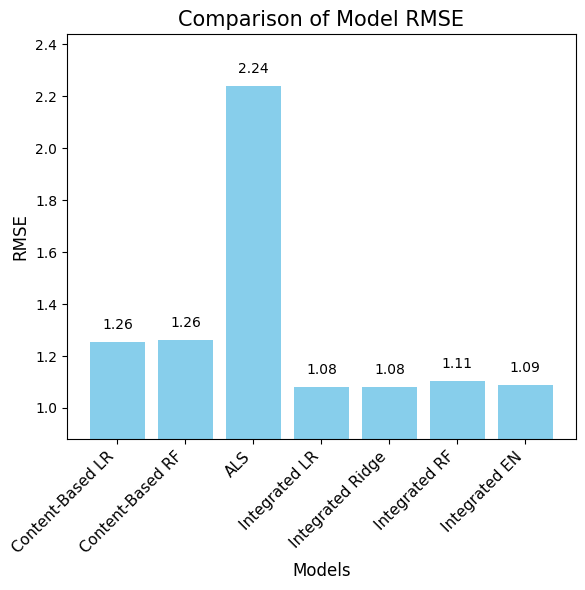

In [76]:
fig, ax = plt.subplots(figsize=(6, 6))

# RMSE Plot
indices = np.arange(len(rmse_values))
ax.bar(indices, rmse_values, color='skyblue')
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Comparison of Model RMSE', fontsize=15)
ax.set_xticks(indices)
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=11)
ax.set_ylim(min(rmse_values) - 0.2, max(rmse_values) + 0.2)

# Add value labels on top of each bar
for i, v in enumerate(rmse_values):
    ax.text(i, v + 0.05, f"{v:.2f}", ha='center', color='black')

plt.tight_layout()
plt.show()


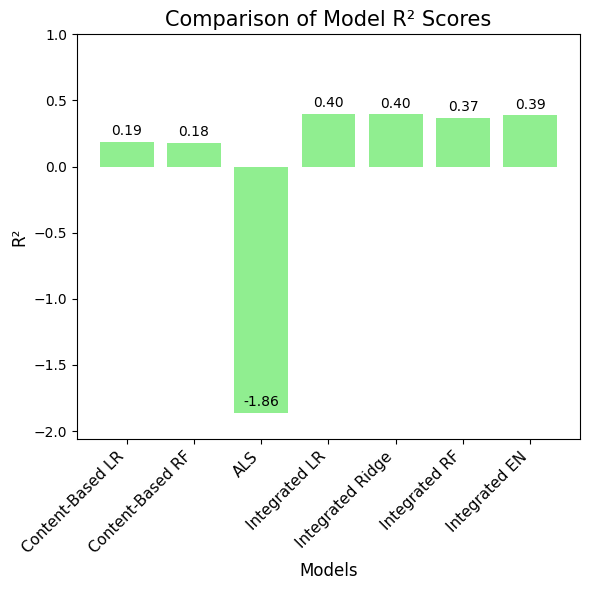

In [71]:
fig, ax = plt.subplots(figsize=(, 6))

# R² Plot
indices = np.arange(len(r2_values))
ax.bar(indices, r2_values, color='lightgreen')
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('R²', fontsize=12)
ax.set_title('Comparison of Model R² Scores', fontsize=15)
ax.set_xticks(indices)
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=11)
ax.set_ylim(min(r2_values) - 0.2, 1)  # Adjust ylim to give some space for the negative value

# Add value labels on top of each bar
for i, v in enumerate(r2_values):
    ax.text(i, v + 0.05, f"{v:.2f}", ha='center', color='black')

plt.tight_layout()
plt.show()


In [78]:
# Labels for the models and experiments
experiments = ['Experiment 1', 'Experiment 2', 'Experiment 3']
models = ['Linear Regression', 'Ridge Regression', 'Random Forest', 'Elastic Net']

# RMSE values for each model in each experiment
rmse_values = {
    'Linear Regression': [1.3637, 1.0800, 1.0815],
    'Ridge Regression': [1.3638, 1.0813, 1.0830],
    'Random Forest': [1.3645, 1.1054, 1.2283],
    'Elastic Net': [1.3842, 1.0883, 1.1854]
}

# R^2 values for each model in each experiment
r2_values = {
    'Linear Regression': [0.0393, 0.3974, 0.3958],
    'Ridge Regression': [0.0392, 0.3960, 0.3941],
    'Random Forest': [0.0382, 0.3688, 0.2206],
    'Elastic Net': [0.0101, 0.3881, 0.2741]
}


In [94]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(values, title, ylabel, ylim=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = 0.2
    colors = ['steelblue', 'forestgreen', 'salmon', 'orange']

    # Create bars for each model
    for i, model in enumerate(models):
        offsets = np.arange(len(experiments))  # the label locations
        ax.bar(offsets + i*bar_width, values[model], width=bar_width, label=model, color=colors[i])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Experiments', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=15)
    ax.set_xticks(offsets + bar_width + bar_width/2)
    ax.set_xticklabels(experiments)
    ax.legend()

    if ylim:
        ax.set_ylim(ylim)

    # Add value labels on top of each bar
    for i, model in enumerate(models):
        for idx, val in enumerate(values[model]):
            ax.text(idx + i*bar_width, val + 0.01, f"{val:.2f}", ha='center')

    plt.tight_layout()
    plt.show()


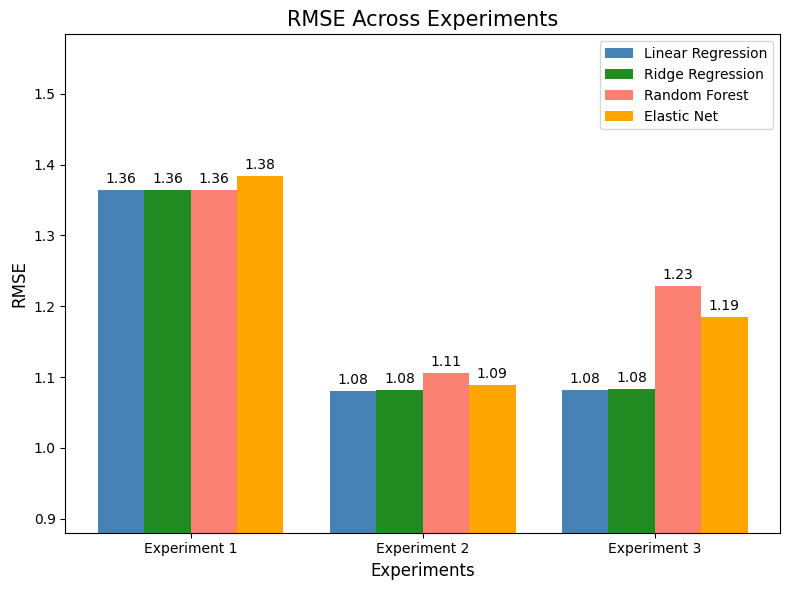

In [95]:
plot_metrics(rmse_values, 'RMSE Across Experiments', 'RMSE', [min(min(rmse_values.values())) - 0.2, max(max(rmse_values.values())) + 0.2])

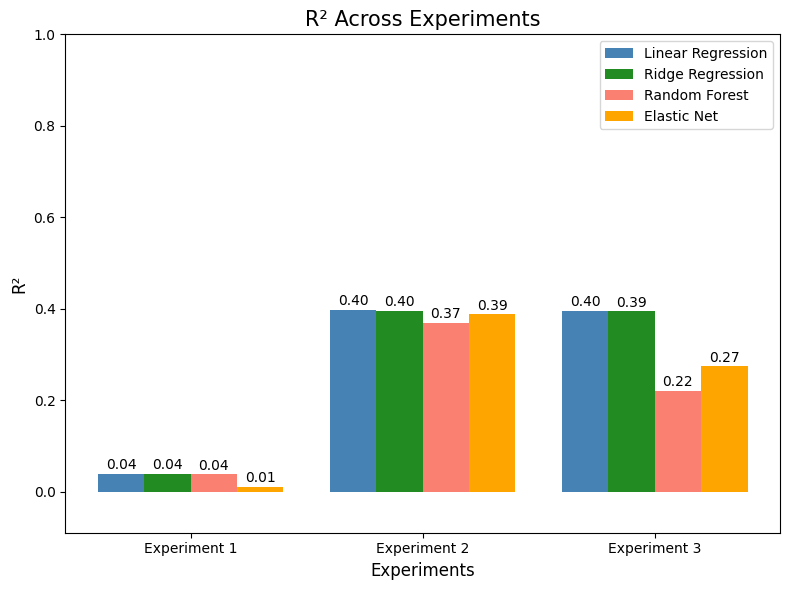

In [96]:
plot_metrics(r2_values, 'R² Across Experiments', 'R²', [min(min(r2_values.values())) - 0.1, 1])